# E-Commerce Customer Segmentation And Prediction

# 1.Data Preprocessing

# <b>Load Liabraries Import Liabraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN,AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# ML Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# <b> Load The Dataset

In [6]:
df = pd.read_csv("data.csv", encoding='latin1', low_memory=False)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# <b> Data Preprocessing

In [8]:
print(df.shape)
df.info()
df.describe()


(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Handle Missing values

In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<Axes: >

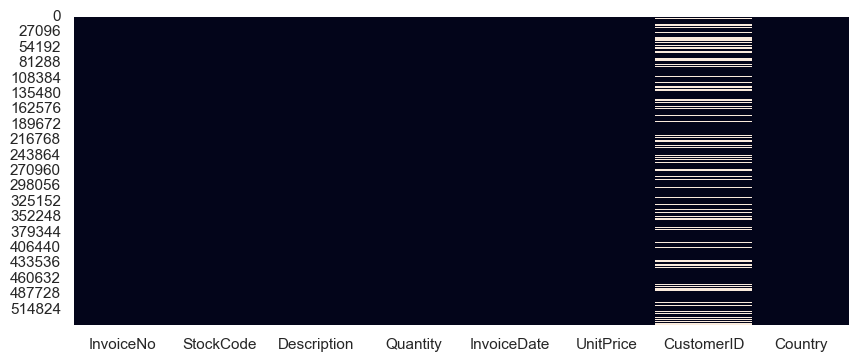

In [11]:
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)

In [12]:
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate Rows: 5268


In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(str)

# <b> Handling Missing Values

In [8]:
df = df.dropna(subset=['CustomerID'])     # drop null customers
df = df[df['Quantity'] > 0]               # remove cancelled orders
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# EDA Explolatary Data Analysis

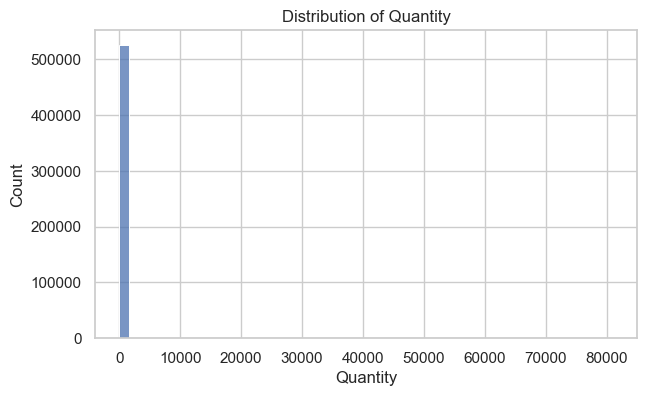

In [9]:
plt.figure(figsize=(7,4))
sns.histplot(df['Quantity'], bins=50)
plt.title("Distribution of Quantity")
plt.show()

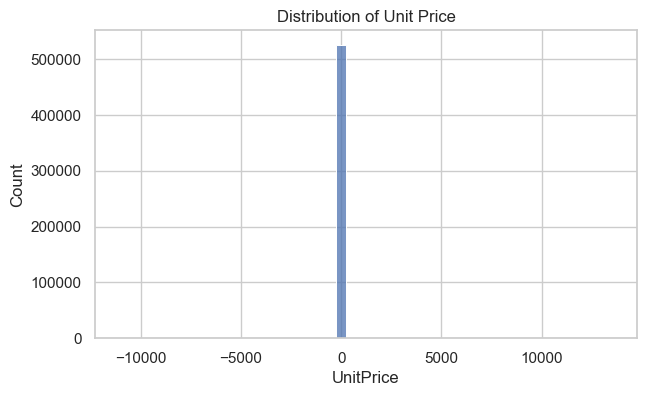

In [10]:
plt.figure(figsize=(7,4))
sns.histplot(df['UnitPrice'], bins=50)
plt.title("Distribution of Unit Price")
plt.show()


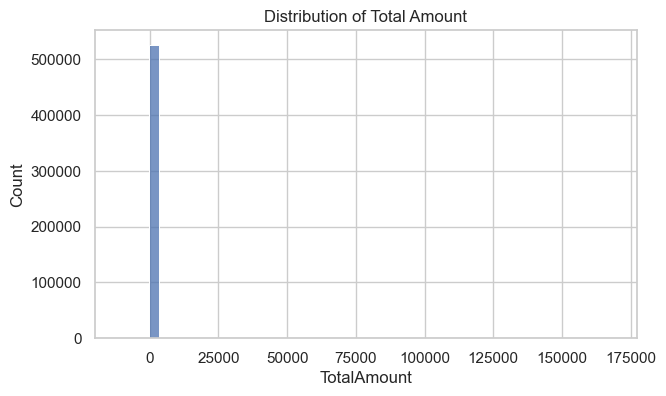

In [11]:
plt.figure(figsize=(7,4))
sns.histplot(df['TotalAmount'], bins=50)
plt.title("Distribution of Total Amount")
plt.show()

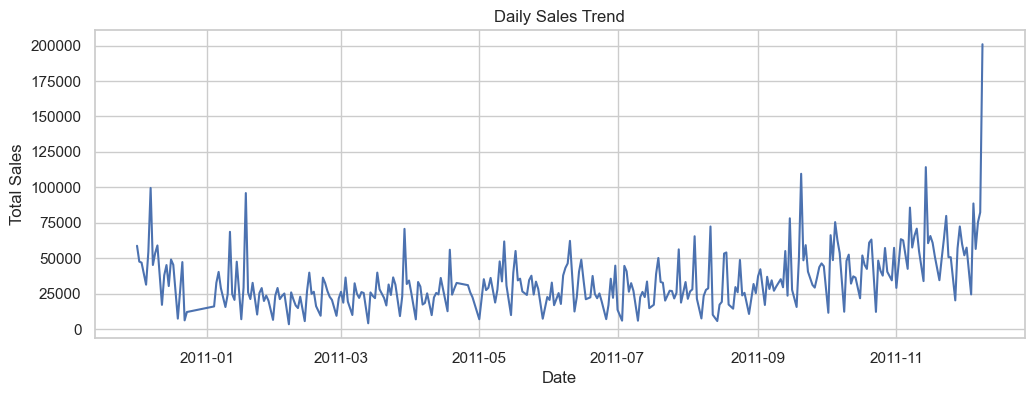

In [12]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()

plt.figure(figsize=(12,4))
daily_sales.plot()
plt.title("Daily Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Date")
plt.show()

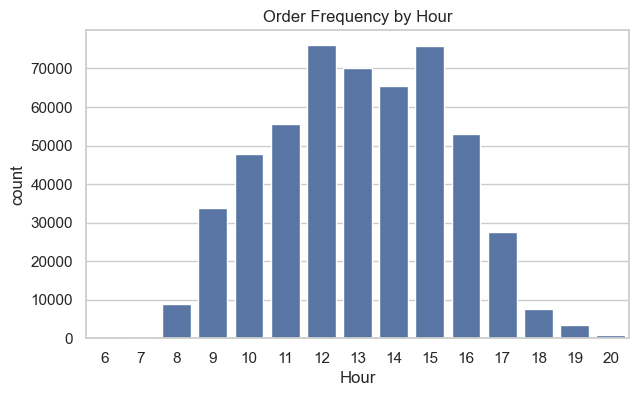

In [13]:
df['Hour'] = df['InvoiceDate'].dt.hour

plt.figure(figsize=(7,4))
sns.countplot(x='Hour', data=df)
plt.title("Order Frequency by Hour")
plt.show()

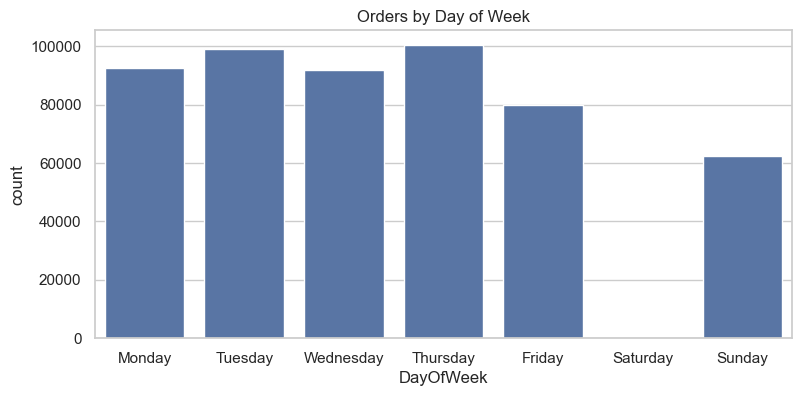

In [14]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

plt.figure(figsize=(9,4))
sns.countplot(x='DayOfWeek', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Orders by Day of Week")
plt.show()

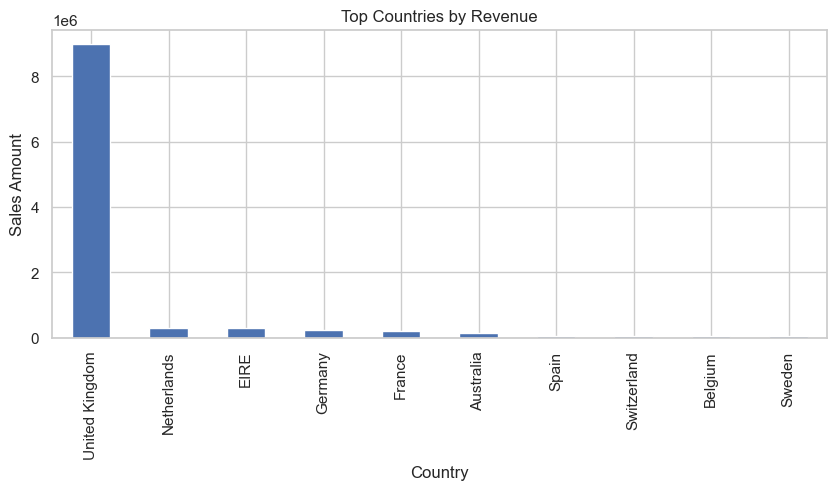

In [15]:
country_sales = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
country_sales.head(10).plot(kind='bar')
plt.title("Top Countries by Revenue")
plt.ylabel("Sales Amount")
plt.show()

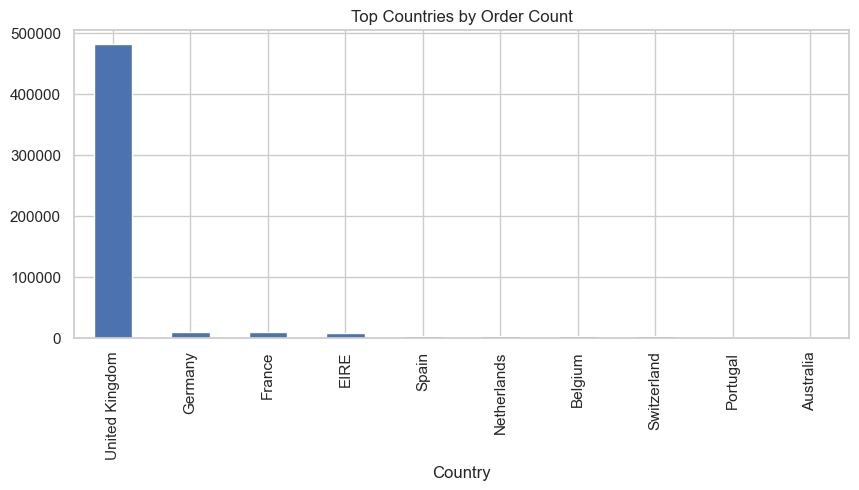

In [16]:
plt.figure(figsize=(10,4))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top Countries by Order Count")
plt.show()


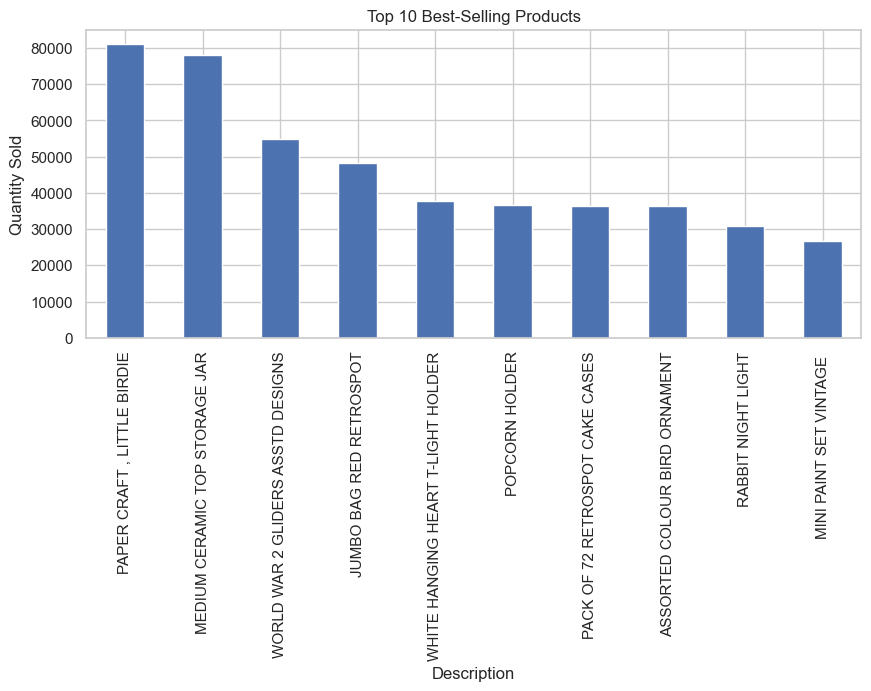

In [17]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
top_products.plot(kind='bar')
plt.title("Top 10 Best-Selling Products")
plt.ylabel("Quantity Sold")
plt.show()

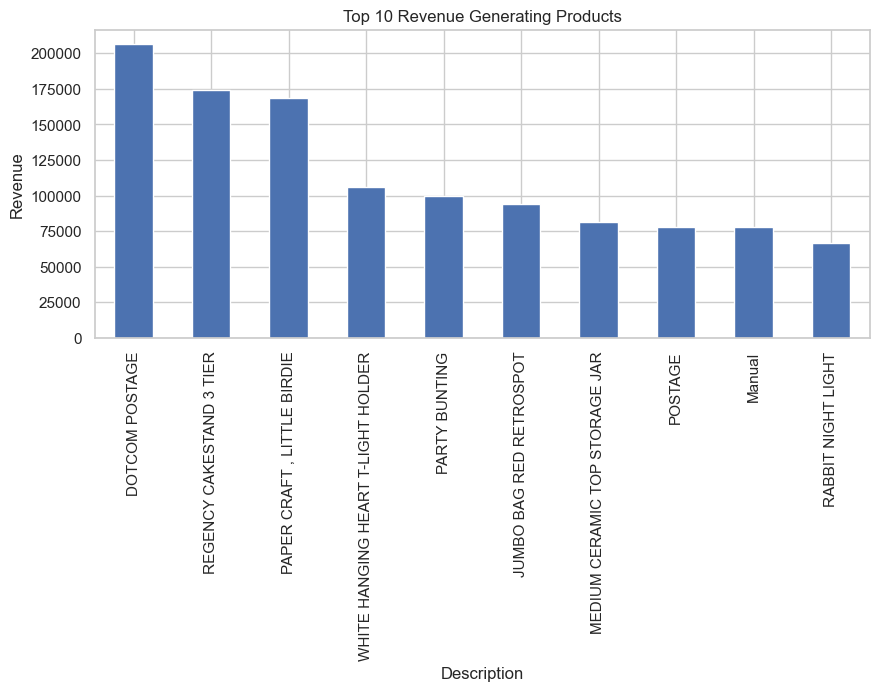

In [18]:
top_revenue_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
top_revenue_products.plot(kind='bar')
plt.title("Top 10 Revenue Generating Products")
plt.ylabel("Revenue")
plt.show()

# RFM

In [19]:
from datetime import timedelta

reference_date = df['InvoiceDate'].max() + timedelta(days=1)

RFM = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
})

RFM.columns = ['Recency', 'Frequency', 'Monetary']
RFM.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


# Calculate Recency, Frequency, and Monetary value (RFM)

In [48]:
# Calculate Recency, Frequency, and Monetary value (RFM)

snapshot_date = max(df['InvoiceDate']) + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'count',                                      # Frequency
    'TotalAmount': 'sum'                                        # Monetary
}).reset_index()

# Rename columns to match the slide format
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Estimate Customer Lifetime Value (CLV)
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency']

# Display the RFM table
print(rfm.head())


  CustomerID  Recency  Frequency  Monetary        CLV
0    12346.0      326          1  77183.60   77183.60
1    12347.0        2        182   4310.00  784420.00
2    12348.0       75         31   1797.24   55714.44
3    12349.0       19         73   1757.55  128301.15
4    12350.0      310         17    334.40    5684.80


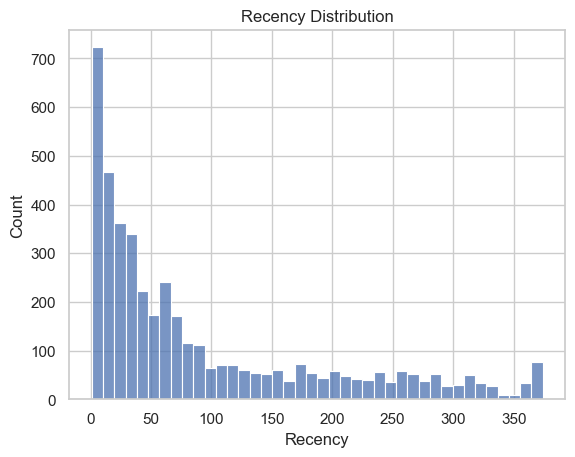

In [50]:
sns.histplot(RFM['Recency'], bins=40)
plt.title("Recency Distribution")
plt.show()

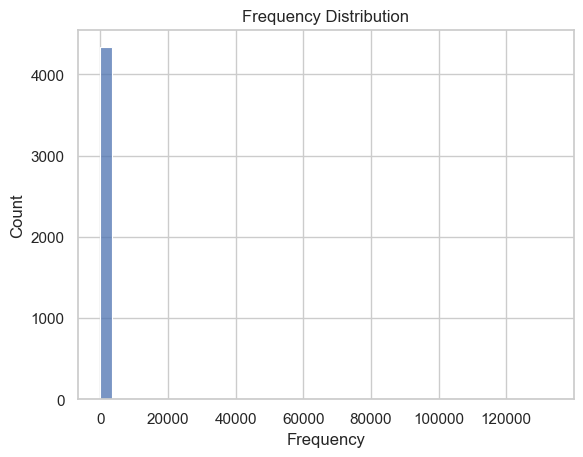

In [51]:
sns.histplot(RFM['Frequency'], bins=40)
plt.title("Frequency Distribution")
plt.show()

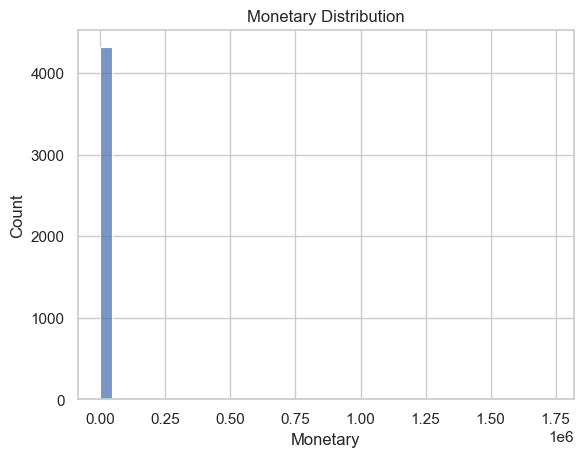

In [52]:
sns.histplot(RFM['Monetary'], bins=40)
plt.title("Monetary Distribution")
plt.show()

# RFM Correlation Heatmap

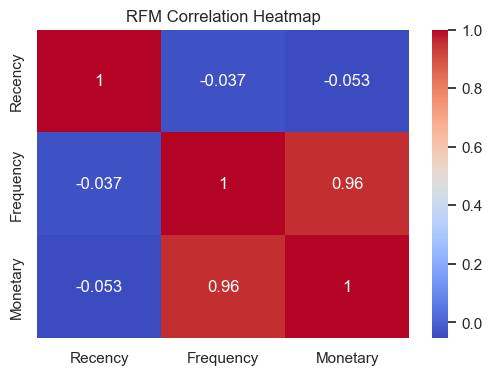

In [53]:
plt.figure(figsize=(6,4))
sns.heatmap(RFM.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Correlation Heatmap")
plt.show()

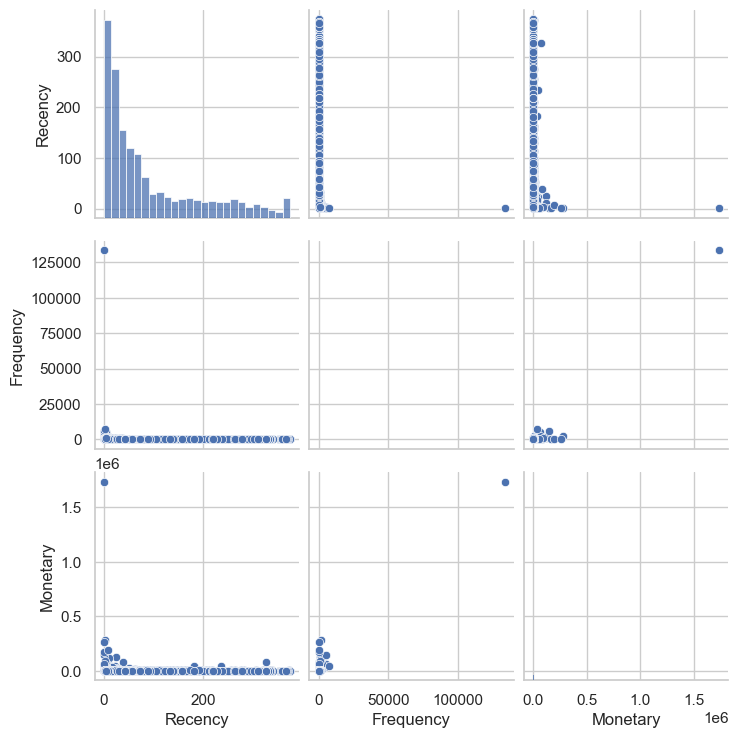

In [54]:
sns.pairplot(RFM)
plt.show()

In [55]:
RFM['AOV'] = RFM['Monetary'] / RFM['Frequency']

In [56]:
purchase_frequency = RFM['Frequency'].mean()
purchase_frequency

121.21059907834102

In [57]:
customer_lifespan_years = 1.0

In [58]:
RFM['CLV'] = RFM['AOV'] * purchase_frequency * customer_lifespan_years

# Normalize values

In [59]:
# Normalize values
RFM_norm = (RFM[['Recency','Frequency','Monetary']] - RFM[['Recency','Frequency','Monetary']].min()) / \
            (RFM[['Recency','Frequency','Monetary']].max() - RFM[['Recency','Frequency','Monetary']].min())

# Weighted CLV Score
RFM['CLV_weighted'] = (0.15 * (1 - RFM_norm['Recency'])) + \
                      (0.40 * RFM_norm['Frequency']) + \
                      (0.45 * RFM_norm['Monetary'])

# Scale to money values
RFM['CLV_weighted'] = RFM['CLV_weighted'] * RFM['Monetary'].max()

In [60]:
discount_rate = 0.10

RFM['CLV_discounted'] = RFM['AOV'] * (purchase_frequency / discount_rate)

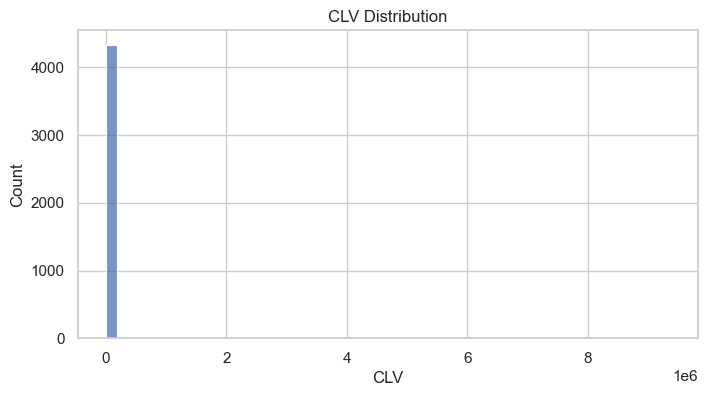

In [61]:
plt.figure(figsize=(8,4))
sns.histplot(RFM['CLV'], bins=50)
plt.title("CLV Distribution")
plt.show()

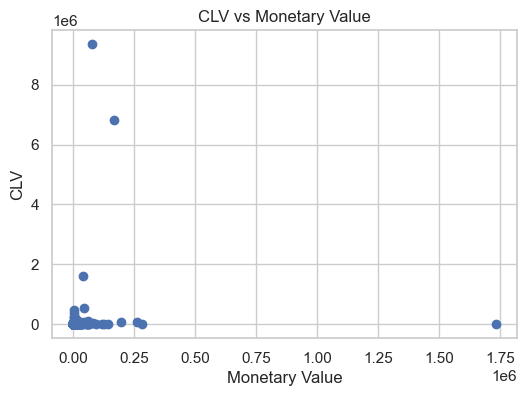

In [62]:
plt.figure(figsize=(6,4))
plt.scatter(RFM['Monetary'], RFM['CLV'])
plt.xlabel("Monetary Value")
plt.ylabel("CLV")
plt.title("CLV vs Monetary Value")
plt.show()

In [63]:
RFM['CLV_segment'] = pd.qcut(RFM['CLV'], q=3, labels=['Low Value', 'Mid Value', 'High Value'])

In [65]:
RFM[['CLV', 'CLV_weighted', 'CLV_discounted']].describe()

,CLV,CLV_weighted,CLV_discounted
count,4.340000e+03,4.340000e+03,4.340000e+03
mean,8.281348e+03,1.978850e+05,8.281348e+04
std,1.778858e+05,7.431462e+04,1.778858e+06
min,0.000000e+00,3.582000e+01,0.000000e+00
25%,1.501844e+03,1.618773e+05,1.501844e+04
50%,2.150007e+03,2.259057e+05,2.150007e+04
75%,3.013733e+03,2.494994e+05,3.013733e+04
max,9.355470e+06,1.732778e+06,9.355470e+07


In [66]:
RFM.head()

,Recency,Frequency,Monetary,AOV,CLV,CLV_weighted,CLV_discounted,CLV_segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,77183.600000,9.355470e+06,68180.341416,9.355470e+07,High Value
12347.0,2,182,4310.00,23.681319,2.870427e+03,262100.326352,2.870427e+04,High Value
12348.0,75,31,1797.24,57.975484,7.027243e+03,209316.153746,7.027243e+04,High Value
12349.0,19,73,1757.55,24.076027,2.918270e+03,248538.985096,2.918270e+04,High Value
12350.0,310,17,334.40,19.670588,2.384284e+03,44830.622916,2.384284e+04,Mid Value


<Axes: xlabel='Hour', ylabel='count'>

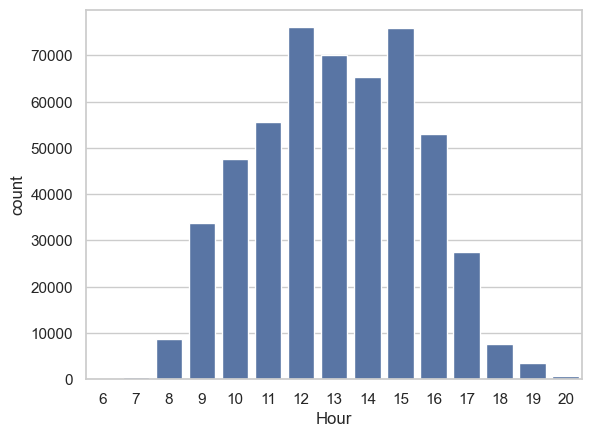

In [67]:
df['Hour'] = df['InvoiceDate'].dt.hour
sns.countplot(x=df['Hour'])

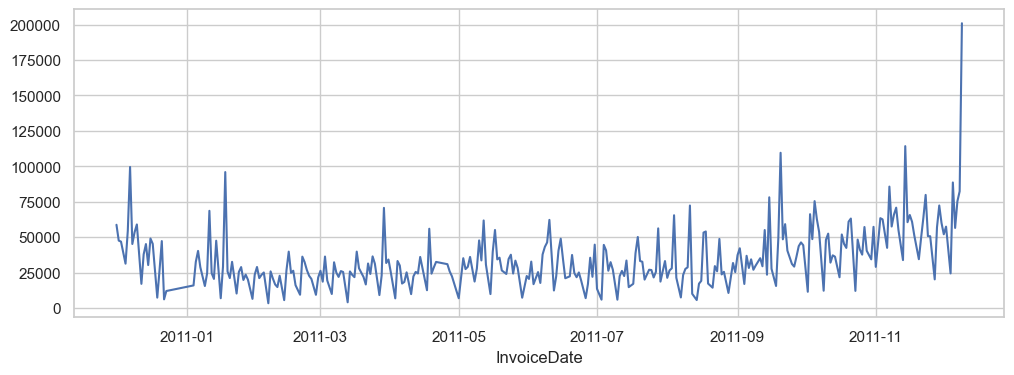

In [68]:
daily = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()
daily.plot(figsize=(12,4))
plt.show()

<Axes: xlabel='Country'>

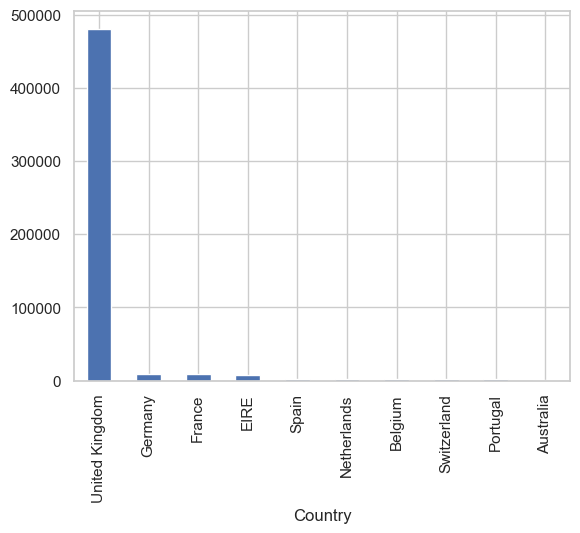

In [69]:
df['Country'].value_counts().head(10).plot(kind='bar')

In [70]:
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM[['Recency','Frequency','Monetary']])

In [71]:
kmeans = KMeans(n_clusters=4, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(RFM_scaled)

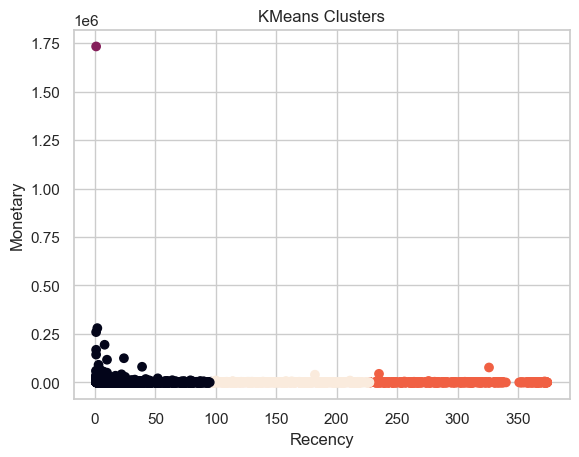

In [72]:
plt.scatter(RFM['Recency'], RFM['Monetary'], c=RFM['Cluster'])
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("KMeans Clusters")
plt.show()

# Elbow Method

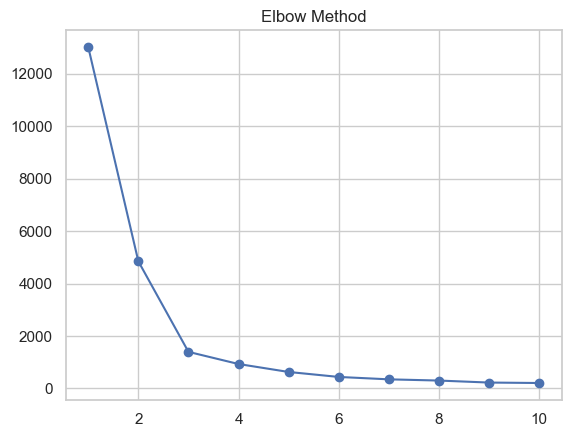

In [73]:
sse = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(RFM_scaled)
    sse.append(km.inertia_)

plt.plot(K, sse, marker='o')
plt.title("Elbow Method")
plt.show()

# Dendogram

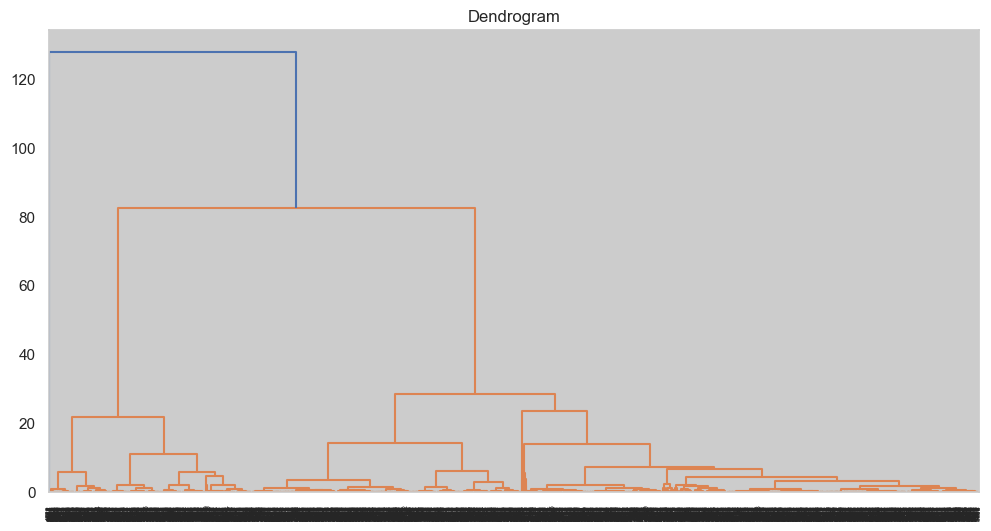

In [75]:
plt.figure(figsize=(12,6))
sch.dendrogram(sch.linkage(RFM_scaled, method='ward'))
plt.title("Dendrogram")
plt.show()

In [76]:
db = DBSCAN(eps=0.5, min_samples=5)
RFM['DBSCAN'] = db.fit_predict(RFM_scaled)

# PCA Customer Segmentation

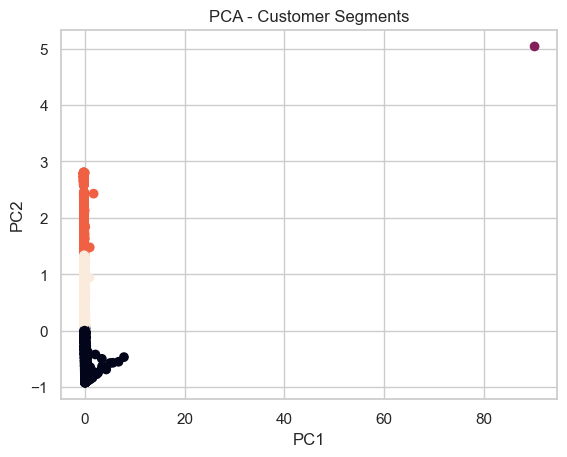

In [77]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(RFM_scaled)

plt.scatter(pca_data[:,0], pca_data[:,1], c=RFM['Cluster'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - Customer Segments")
plt.show()


# Agglomerative Clustering

In [78]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',  
    linkage='ward'
)
RFM['HC_Cluster'] = hc.fit_predict(RFM_scaled)

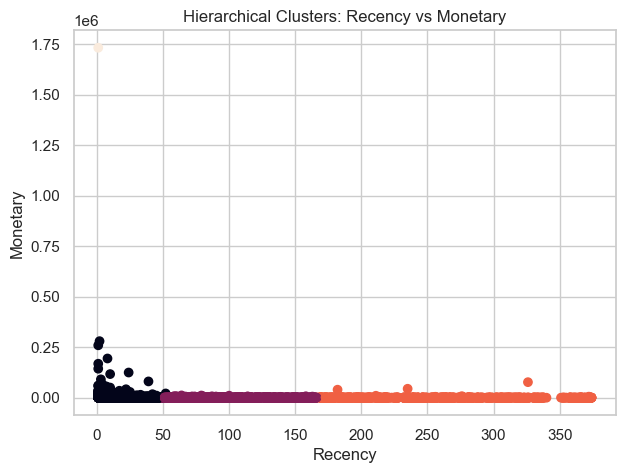

In [79]:
plt.figure(figsize=(7,5))
plt.scatter(RFM['Recency'], RFM['Monetary'], c=RFM['HC_Cluster'])
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("Hierarchical Clusters: Recency vs Monetary")
plt.show()

In [80]:
from sklearn.metrics import silhouette_score

In [81]:
kmeans = KMeans(n_clusters=4, random_state=42)
RFM['KMeans_Cluster'] = kmeans.fit_predict(RFM_scaled)

In [82]:
kmeans_sil = silhouette_score(RFM_scaled, RFM['KMeans_Cluster'])
print("KMeans Silhouette Score:", kmeans_sil)

KMeans Silhouette Score: 0.6353696897465844


In [83]:
hc_sil = silhouette_score(RFM_scaled, RFM['HC_Cluster'])
print("Hierarchical Silhouette Score:", hc_sil)

Hierarchical Silhouette Score: 0.5424044735549997


In [84]:
print("=== Silhouette Score Comparison ===")
print(f"KMeans Score: {kmeans_sil}")
print(f"Hierarchical Score: {hc_sil}")

if kmeans_sil > hc_sil:
    print("\nKMeans performs better based on Silhouette Score.")
else:
    print("\nHierarchical Clustering performs better based on Silhouette Score.")

=== Silhouette Score Comparison ===
KMeans Score: 0.6353696897465844
Hierarchical Score: 0.5424044735549997

KMeans performs better based on Silhouette Score.


In [85]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [86]:
X = RFM[['Recency', 'Frequency', 'Monetary']]
y = RFM['Cluster']   # or 'HC_Cluster' for hierarchical

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [87]:
dt = DecisionTreeClassifier(
    criterion='gini',    # or 'entropy'
    max_depth=5,
    random_state=42
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [88]:
y_pred = dt.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.999231950844854

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00       178
           3       1.00      1.00      1.00       254

    accuracy                           1.00      1302
   macro avg       0.75      0.75      0.75      1302
weighted avg       1.00      1.00      1.00      1302



# Decision Tree Structure

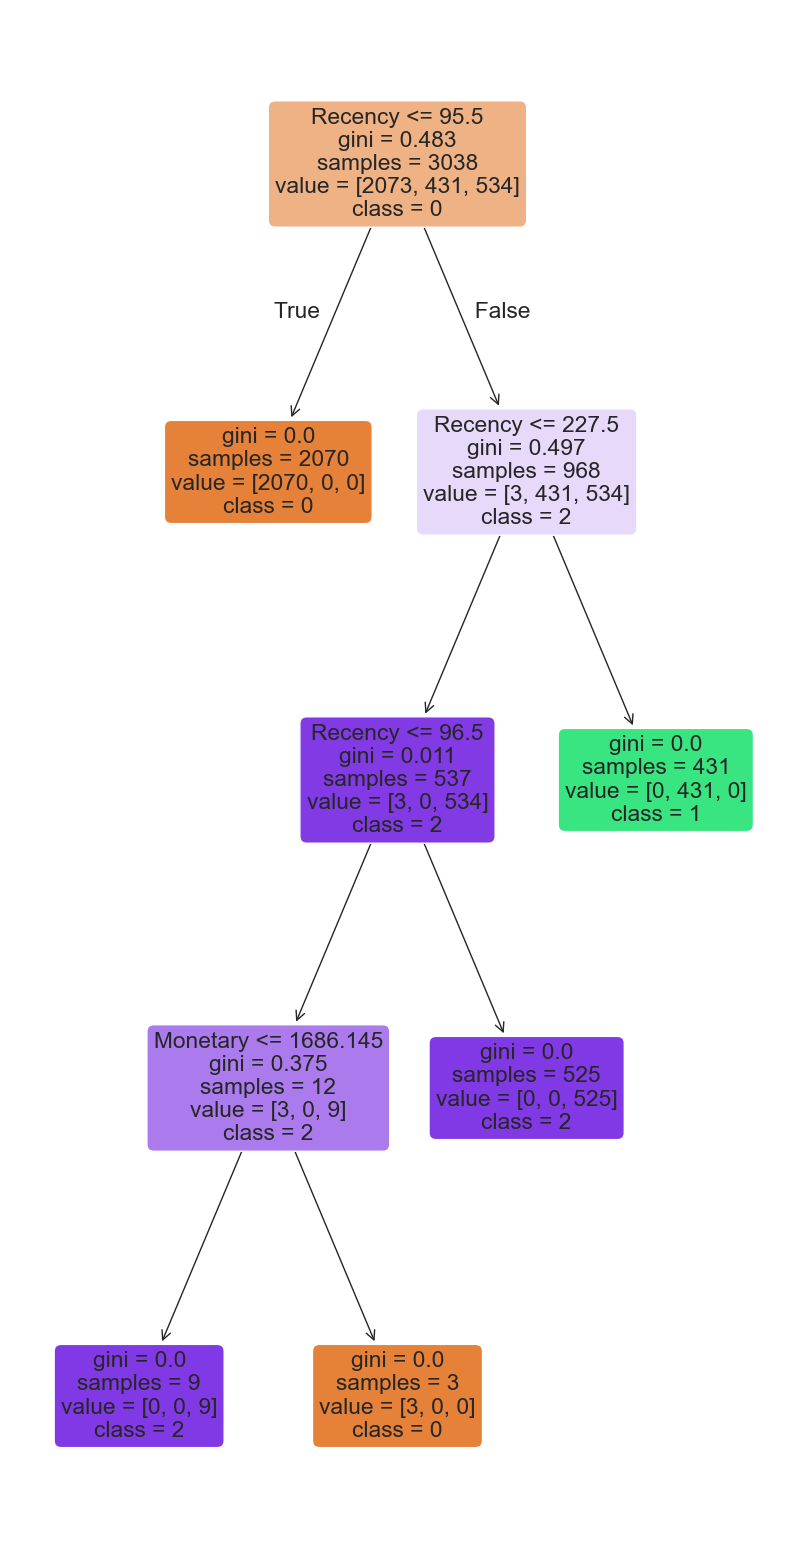

In [89]:
plt.figure(figsize=(10,20))
plot_tree(
    dt,
    feature_names=['Recency', 'Frequency', 'Monetary'],
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True
)
plt.show()

In [90]:
X = RFM[['Recency','Frequency','Monetary']]
y = RFM['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Using Maching Learning Models 

In [91]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Accuracy: 0.999231950844854
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00       178
           3       1.00      1.00      1.00       254

    accuracy                           1.00      1302
   macro avg       0.75      0.75      0.75      1302
weighted avg       1.00      1.00      1.00      1302



In [92]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred))

KNN Accuracy: 0.9600614439324117


In [93]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.6674347158218126


In [94]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred))

RF Accuracy: 0.999231950844854


In [95]:
models = {
    "Logistic": lr,
    "KNN": knn,
    "SVM": svm,
    "RandomForest": rf
}

for name, model in models.items():
    pred = model.predict(X_test)
    print(name, "Accuracy:", accuracy_score(y_test, pred))

Logistic Accuracy: 0.999231950844854
KNN Accuracy: 0.9600614439324117
SVM Accuracy: 0.6674347158218126
RandomForest Accuracy: 0.999231950844854


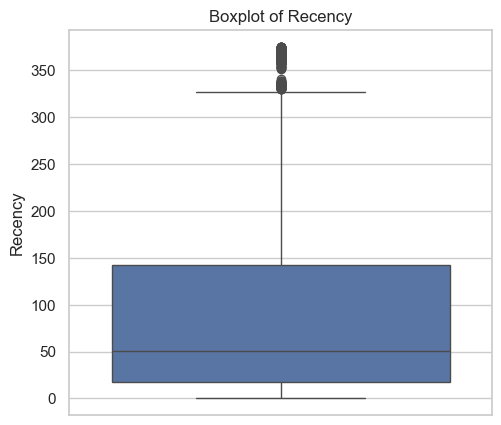

In [159]:
plt.figure(figsize=(12,5))
# Boxplot for Recency
plt.subplot(1, 2, 1)
sns.boxplot(y=RFM['Recency'])
plt.title("Boxplot of Recency")
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 2)
sns.boxplot(y=RFM['Frequency'])
plt.title("Boxplot of Frequency")

plt.tight_layout()
plt.show()